# Packages Imports

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

# Loading Data

In [3]:
# Defining the path for train and test images
data_dir = pathlib.Path("../input/plantvillage-dataset/color")
train='../input/plantvillage-dataset/color'

In [4]:
dataset_path_train = os.listdir(data_dir)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [5]:
image_count_train = len(list(data_dir.glob('*/*.JPG')))
print("The number of Train data:",image_count_train)

The number of Train data: 52803


In [6]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 224
img_width = 224

In [7]:
# For train data set
train_ds = image_dataset_from_directory(data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [8]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [9]:
# here we can put the test data
test = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=None)

Found 54305 files belonging to 38 classes.


In [10]:
# Here We give the name of the data the we found the Benign dataset and malignant
class_names = train_ds.class_names
print(len(class_names))
print( class_names)


38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


# Creat Model


In [12]:
num_classes = 38

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [14]:
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0

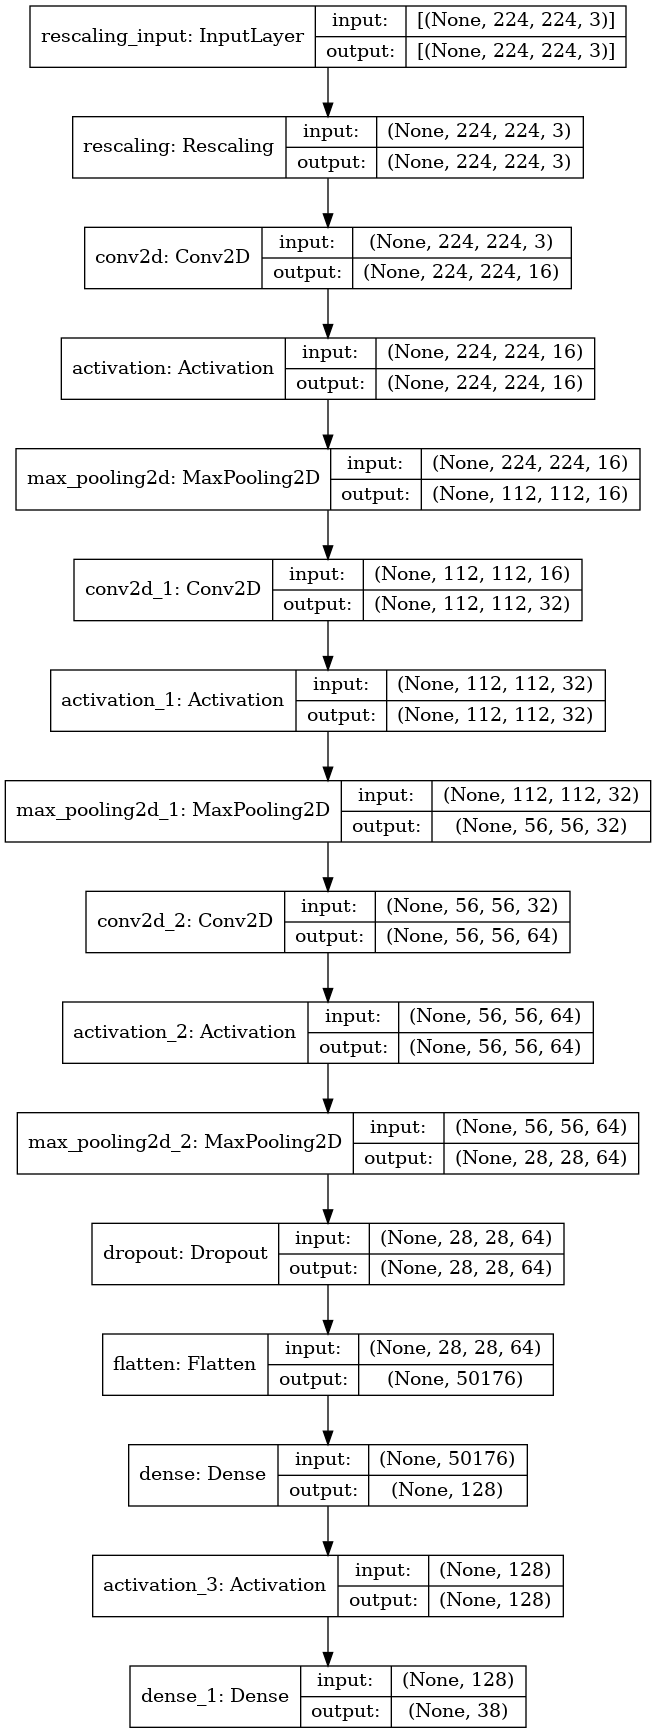

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

In [17]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1186/1358 [=========================>....] - ETA: 1:06 - loss: 1.0344 - accuracy: 0.7054

Cleanup called...


1358/1358 [==============================] - 565s 415ms/step - loss: 0.9714 - accuracy: 0.7216 - val_loss: 0.4960 - val_accuracy: 0.8457
Epoch 2/10
1186/1358 [=========================>....] - ETA: 1:04 - loss: 0.3464 - accuracy: 0.8913

Cleanup called...


1358/1358 [==============================] - 545s 401ms/step - loss: 0.3364 - accuracy: 0.8941 - val_loss: 0.5178 - val_accuracy: 0.8420
Epoch 3/10
1186/1358 [=========================>....] - ETA: 1:05 - loss: 0.1798 - accuracy: 0.9420

Cleanup called...


1358/1358 [==============================] - 550s 405ms/step - loss: 0.1782 - accuracy: 0.9426 - val_loss: 0.4068 - val_accuracy: 0.8832
Epoch 4/10
1186/1358 [=========================>....] - ETA: 1:04 - loss: 0.1127 - accuracy: 0.9619

Cleanup called...


1358/1358 [==============================] - 544s 401ms/step - loss: 0.1123 - accuracy: 0.9618 - val_loss: 0.4039 - val_accuracy: 0.8972
Epoch 5/10
1186/1358 [=========================>....] - ETA: 1:04 - loss: 0.0833 - accuracy: 0.9725

Cleanup called...


1358/1358 [==============================] - 545s 401ms/step - loss: 0.0821 - accuracy: 0.9729 - val_loss: 0.4912 - val_accuracy: 0.8789
Epoch 6/10
1186/1358 [=========================>....] - ETA: 1:04 - loss: 0.0744 - accuracy: 0.9757

Cleanup called...


1358/1358 [==============================] - 548s 403ms/step - loss: 0.0730 - accuracy: 0.9760 - val_loss: 0.3579 - val_accuracy: 0.9167
Epoch 7/10
1186/1358 [=========================>....] - ETA: 1:04 - loss: 0.0646 - accuracy: 0.9792

Cleanup called...


1358/1358 [==============================] - 546s 402ms/step - loss: 0.0629 - accuracy: 0.9796 - val_loss: 0.4669 - val_accuracy: 0.9025
Epoch 8/10
1186/1358 [=========================>....] - ETA: 1:03 - loss: 0.0537 - accuracy: 0.9827

Cleanup called...


1358/1358 [==============================] - 540s 398ms/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 0.3642 - val_accuracy: 0.9225
Epoch 9/10
1186/1358 [=========================>....] - ETA: 1:03 - loss: 0.0464 - accuracy: 0.9852

Cleanup called...


1358/1358 [==============================] - 539s 397ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 0.5406 - val_accuracy: 0.8938
Epoch 10/10
1186/1358 [=========================>....] - ETA: 1:03 - loss: 0.0472 - accuracy: 0.9851

Cleanup called...


1358/1358 [==============================] - 537s 396ms/step - loss: 0.0489 - accuracy: 0.9845 - val_loss: 0.4459 - val_accuracy: 0.9121


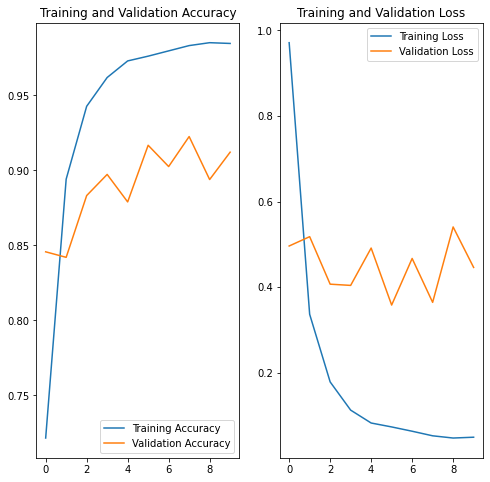

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
preformance = model.evaluate(val_ds)

340/340 [==============================] - 37s 107ms/step - loss: 0.4459 - accuracy: 0.9121


In [20]:
preformance

[0.44590967893600464, 0.9120706915855408]

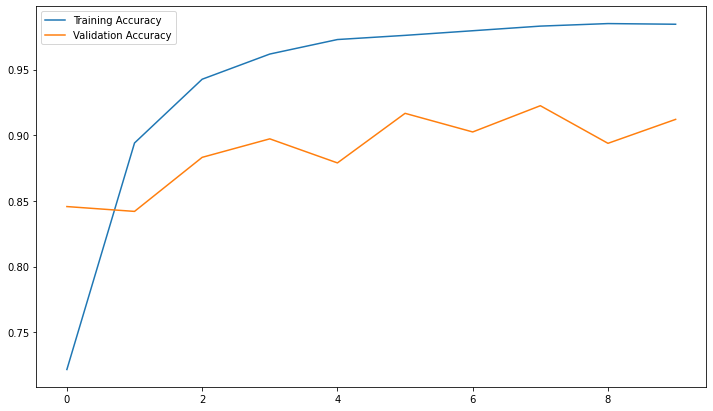

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
no_of_epochs = history.params['epochs']
len(history.history['accuracy']) == no_of_epochs
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), acc, label='Training Accuracy')
plt.plot(range(no_of_epochs), val_acc, label='Validation Accuracy')

plt.legend()
plt.show()

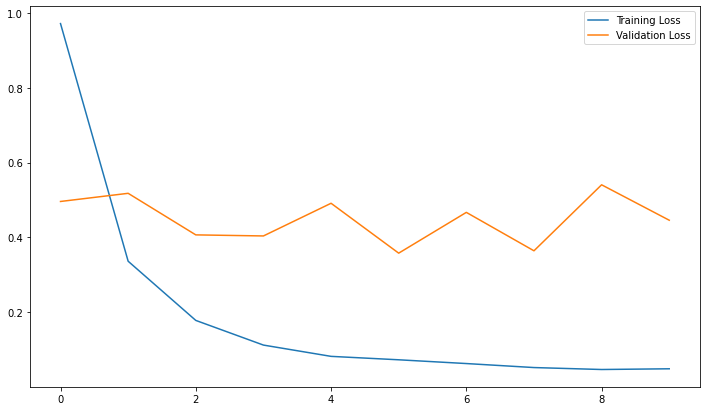

In [22]:
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), loss, label='Training Loss')
plt.plot(range(no_of_epochs), val_loss, label='Validation Loss')

plt.legend()
plt.show()

actual label: Grape___healthy
predicted label: Grape___healthy


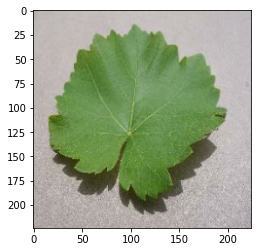

In [23]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in test.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [25]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

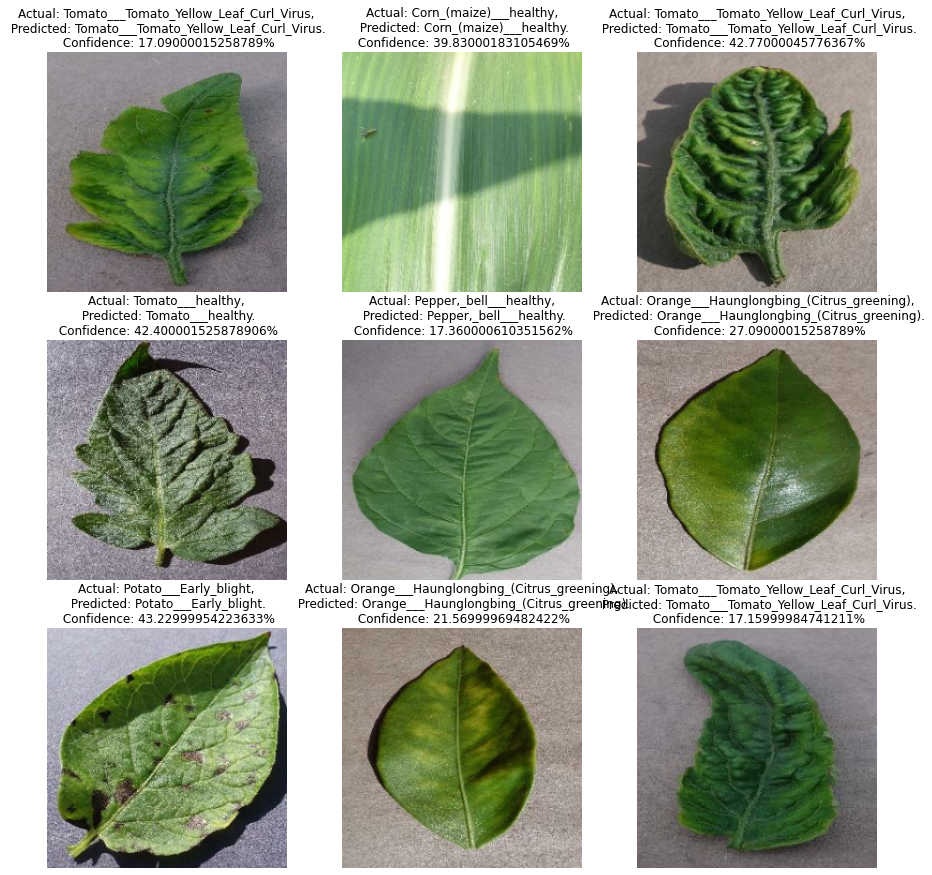

In [26]:
plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
model.save("Model.h5")